In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gluonts.model.seasonal_naive import SeasonalNaivePredictor
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.split import split
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas

#### Load the data

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/AileenNielsen/"
    "TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",
    index_col=0,
    parse_dates=True,
)

#### Convert Pandas DataFrame to GluonTS Pandas Dataset

In [3]:
dataset = PandasDataset(df, target="#Passengers")

#### Train, validation, test split

In [4]:
training_data, test_gen = split(dataset, offset=-24)
test_data = test_gen.generate_instances(prediction_length=12, windows=2, distance=12)

#### Lets Start with a Seasonal Naive model

In [5]:
predictor = SeasonalNaivePredictor(freq="M", prediction_length=12, season_length=12)

In [6]:
forecasts = list(predictor.predict(test_data.input))

#### Plot the predictions

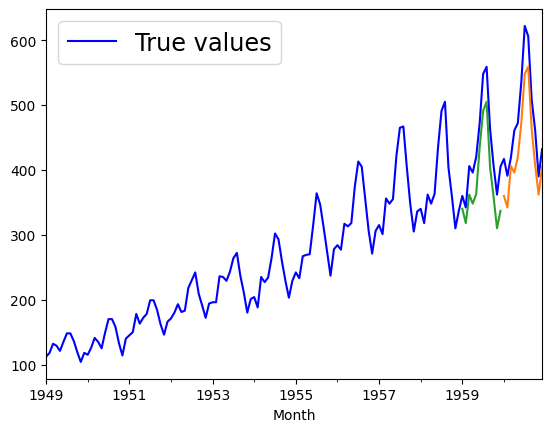

In [7]:
def plot_predictions():
    df["#Passengers"].plot(color="blue")
    for forecast, color in zip(forecasts, ["green", "orange"]):
        forecast.plot(color=f"tab:{color}")
    plt.legend(["True values"], loc="upper left", fontsize="xx-large")

plot_predictions()

### Evaluate the performance of the model

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [9]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 18.52it/s]


In [10]:
agg_metrics

{'MSE': 1357.7083333333333,
 'abs_error': 719.0,
 'abs_target_sum': 9712.0,
 'abs_target_mean': 404.66666666666663,
 'seasonal_error': 29.57349537037037,
 'MASE': 1.0340488064468762,
 'MAPE': 0.07096503555238501,
 'sMAPE': 0.07490740530086978,
 'MSIS': 41.361952257875046,
 'QuantileLoss[0.1]': 143.79999999999998,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.2]': 287.59999999999997,
 'Coverage[0.2]': 0.0,
 'QuantileLoss[0.3]': 431.4,
 'Coverage[0.3]': 0.0,
 'QuantileLoss[0.4]': 575.1999999999999,
 'Coverage[0.4]': 0.0,
 'QuantileLoss[0.5]': 719.0,
 'Coverage[0.5]': 0.0,
 'QuantileLoss[0.6]': 862.8,
 'Coverage[0.6]': 0.0,
 'QuantileLoss[0.7]': 1006.6,
 'Coverage[0.7]': 0.0,
 'QuantileLoss[0.8]': 1150.3999999999999,
 'Coverage[0.8]': 0.0,
 'QuantileLoss[0.9]': 1294.2,
 'Coverage[0.9]': 0.0,
 'RMSE': 36.847093960492096,
 'NRMSE': 0.09105542164866252,
 'ND': 0.0740321252059308,
 'wQuantileLoss[0.1]': 0.01480642504118616,
 'wQuantileLoss[0.2]': 0.02961285008237232,
 'wQuantileLoss[0.3]': 0.044419

In [11]:
agg_metrics["sMAPE"]

0.07490740530086978

In [12]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,None,1958-01,289.416667,151.0,4572.0,381.000000,30.572917,0.411584,0.031351,0.032201,...,151.0,0.0,181.2,0.0,211.4,0.0,241.6,0.0,271.8,0.0
1,None,1959-01,2426.000000,568.0,5140.0,428.333333,28.574074,1.656513,0.110579,0.117614,...,568.0,0.0,681.6,0.0,795.2,0.0,908.8,0.0,1022.4,0.0


#### GluonTS Comes with a Wrapper around statsforecast, which has the fastest implementation of ARIMA, ETS, and many more

In [13]:
from gluonts.ext.statsforecast import (
    AutoARIMAPredictor, 
    AutoETSPredictor, 
    AutoCESPredictor, 
    AutoThetaPredictor
)

/workspaces/training-code/task_forecasting_training/.venv/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [14]:
predictor = AutoARIMAPredictor(
  prediction_length=12,
  quantile_levels=[0.1, 0.5, 0.9],
)

In [15]:
forecasts = list(predictor.predict(test_data.input))

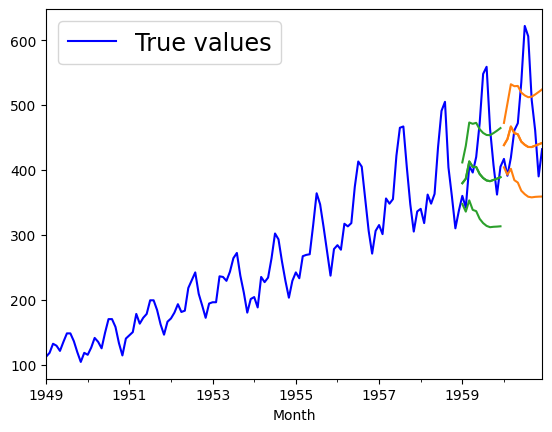

In [16]:
plot_predictions()

### Evaluate the performance of the model

In [17]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [18]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


In [19]:
agg_metrics["sMAPE"]

0.12145660119266259

### Let´s try with Theta

In [20]:
predictor = AutoThetaPredictor(
  prediction_length=12,
  quantile_levels=[0.1, 0.5, 0.9],
)

In [21]:
forecasts = list(predictor.predict(test_data.input))

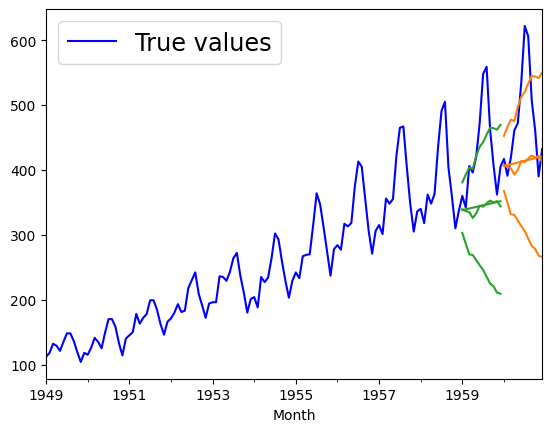

In [22]:
plot_predictions()

In [23]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [24]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 13.15it/s]


In [25]:
agg_metrics["sMAPE"]

0.17085678462344747

GluonTS also comes with a wrapper to R and the `forecast` library

In [26]:
from gluonts.ext.r_forecast import RForecastPredictor

In [40]:
predictor = RForecastPredictor(
    freq="M",
    prediction_length=12,
    method_name="arima",
    period=12,
)

In [41]:
forecasts = list(predictor.predict(test_data.input))

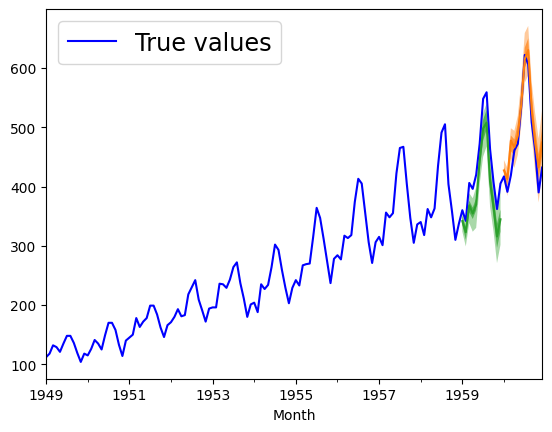

In [42]:
plot_predictions()

In [31]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data.input,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [32]:
agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(test_data.input)
)

Running evaluation: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


In [33]:
agg_metrics["sMAPE"]

0.08074288898242676